In [1]:
import os 
os.environ['KAGGLE_CONFIG_DIR']='.'

In [2]:
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

 93% 49.0M/52.6M [00:02<00:00, 35.5MB/s]
100% 52.6M/52.6M [00:02<00:00, 25.7MB/s]


In [3]:
os.listdir()

['.config',
 'jigsaw-toxic-comment-classification-challenge.zip',
 'kaggle.json',
 'sample_data']

In [4]:
!unzip jigsaw-toxic-comment-classification-challenge.zip -d data

Archive:  jigsaw-toxic-comment-classification-challenge.zip
  inflating: data/sample_submission.csv.zip  
  inflating: data/test.csv.zip       
  inflating: data/test_labels.csv.zip  
  inflating: data/train.csv.zip      


In [5]:
import pandas as pd
train_df=pd.read_csv('data/train.csv.zip')
test_df=pd.read_csv('data/test.csv.zip')
sub_df=pd.read_csv('data/sample_submission.csv.zip')

In [6]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [8]:
train_df[train_df.severe_toxic==1].sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
65990,b073c1977d68f3fa,FUCK YOU!!'FUCK YOU!!'FUCK YOU!!'FUCK YOU!!'FU...,1,1,1,0,1,0
887,026bd33490542b2e,"you gay motherfucker i know where you live,i a...",1,1,1,0,1,1
29831,4f3101a022dde776,MuYou suck asshole ch,1,1,1,0,1,0
149980,64c5e09faef3fed3,You are a duimb fucker! Why do you want to ban...,1,1,1,0,1,0
15167,2807cd0d9d41027f,I don't give a shit this ain't my fuckin accou...,1,1,1,0,1,0


In [9]:
cols=['toxic',	'severe_toxic','obscene','threat',	'insult',	'identity_hate']
for col in cols:
  print(train_df[col].value_counts(normalize=True))

0    0.904156
1    0.095844
Name: toxic, dtype: float64
0    0.990004
1    0.009996
Name: severe_toxic, dtype: float64
0    0.947052
1    0.052948
Name: obscene, dtype: float64
0    0.997004
1    0.002996
Name: threat, dtype: float64
0    0.950636
1    0.049364
Name: insult, dtype: float64
0    0.991195
1    0.008805
Name: identity_hate, dtype: float64


# Prepare the dataset for training

In [10]:
from torchtext.data.utils import get_tokenizer
tokenizer=get_tokenizer('basic_english')

In [11]:
print(tokenizer(train_df.comment_text[0]))

['explanation', 'why', 'the', 'edits', 'made', 'under', 'my', 'username', 'hardcore', 'metallica', 'fan', 'were', 'reverted', '?', 'they', 'weren', "'", 't', 'vandalisms', ',', 'just', 'closure', 'on', 'some', 'gas', 'after', 'i', 'voted', 'at', 'new', 'york', 'dolls', 'fac', '.', 'and', 'please', 'don', "'", 't', 'remove', 'the', 'template', 'from', 'the', 'talk', 'page', 'since', 'i', "'", 'm', 'retired', 'now', '.', '89', '.', '205', '.', '38', '.', '27']


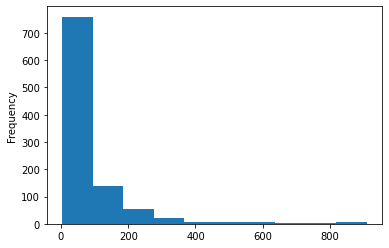

In [12]:
train_df.comment_text.sample(1000).map(tokenizer).map(len).plot(kind='hist')

In [13]:
from torchtext.vocab import build_vocab_from_iterator

In [14]:
comment_tokens = train_df.comment_text.map(tokenizer)
comment_tokens[1][:10]

['d', "'", 'aww', '!', 'he', 'matches', 'this', 'background', 'colour', 'i']

In [15]:
VOCAB_SIZE=2000

In [16]:
unk_token='<unk>'
pad_token='<pad>'

In [17]:
vocab=build_vocab_from_iterator(comment_tokens,
                                specials=[unk_token,pad_token],
                                max_tokens=VOCAB_SIZE)

In [18]:
vocab.set_default_index(vocab[unk_token])
vocab[unk_token]

0

In [19]:
vocab['metallic']

0

In [20]:
comment=train_df.comment_text.values[0]
comment

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [21]:
vocab.lookup_indices(tokenizer(comment))[:10]

[667, 85, 3, 140, 142, 185, 39, 663, 0, 0]

In [22]:
sample_comment_recovered = vocab.lookup_tokens(vocab.lookup_indices(tokenizer(comment))[:10])
sample_comment_recovered[:10]

['explanation',
 'why',
 'the',
 'edits',
 'made',
 'under',
 'my',
 'username',
 '<unk>',
 '<unk>']

In [23]:
max_length=150

In [24]:
def pad_tokens(tokens):
  if (len(tokens) >= max_length):
    return tokens[:max_length]
  else:
    return tokens + [pad_token]*(max_length-len(tokens))

In [ ]:
vocab.lookup_indices(pad_tokens(tokenizer('I am Good. I want to eat Icecream')))

In [26]:
from torch.utils.data import Dataset
import torch

In [27]:
class JigsawDataset(Dataset):
  def __init__(self,df,is_test=False):
    self.df=df
    self.is_test= is_test
  
  def __len__(self):
    return len(self.df)
  
  def __getitem__(self,index):
    context_text = self.df.comment_text.values[index]
    context_tokens = pad_tokens(tokenizer(context_text))
    input = torch.tensor(vocab.lookup_indices(context_tokens))
    if self.is_test:
      target=torch.tensor([0,0,0,0,0,0]).float()
    else:
      target=torch.tensor(self.df[cols].values[index]).float()
    return input,target

In [28]:
train_ds = JigsawDataset(train_df)
test_ds= JigsawDataset(test_df,True)

In [29]:
train_ds[1910]

(tensor([  39,  640,    7,    3,  715,  732,    4,    0,    8,    0,    2,    6,
           25,   67,    0,   24,   11,    0,   21,   18,  304,    2,    0,    5,
            3,  332,   16,    6,  302,   25,   11,    0, 1194,    7,    0,   21,
           11,    0, 1617,    7, 1320,    2,    0,    4,   17,  315,   97,   19,
          400,   59,   12,   11,  388,    0,   21,   77,   33,    2,   48,    6,
          109,    5,    0,   18,    2,    6,   34,  302,  257,    5, 1823,    3,
          574,    2,    0,    2,  271,    2,    6,   25,    5,   43,   13,  300,
          463, 1480,   35,    6,  132,    5,  829,    2,    0,    0,    0,   16,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,  

In [30]:
test_ds[1027]

(tensor([400,  13,  59,  34,  11,   0,   2,   2,   2, 411,   2, 748,   2,   0,
           7,   0,   0,   8,   2,   2,   2,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1]),
 tensor([0., 0., 0., 0., 0., 0.]))

In [31]:
from torch.utils.data import random_split

In [32]:
val_size=0.15

In [33]:
x_train,x_val=random_split(train_ds,[1-val_size,val_size])

In [34]:
len(x_train),len(x_val)

(135636, 23935)

In [35]:
from torch.utils.data import DataLoader
batch_size=256

In [36]:
train_dl=DataLoader(train_ds,batch_size,shuffle=True,pin_memory=True,num_workers=3)
val_dl=DataLoader(train_ds,batch_size*2,pin_memory=True,num_workers=2)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Embedding

In [37]:
import torch.nn as nn
import torch.nn.functional as F

In [38]:
emb_layer=nn.Embedding(VOCAB_SIZE,256,1)

In [39]:
rnn_layer=nn.RNN(256,128,1,batch_first=True)

In [40]:
for batch in train_dl:
  input,target=batch
  print(input.shape)
  print(target.shape)
  
  print(emb_layer(input).shape)
  rnn,hn= rnn_layer(emb_layer(input))
  print(rnn.shape)
  print(hn.shape)
  break

torch.Size([256, 150])
torch.Size([256, 6])
torch.Size([256, 150, 256])
torch.Size([256, 150, 128])
torch.Size([1, 256, 128])


In [41]:
!pip install pytorch_lightning --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 KB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 50.0 MB/s eta 0:00:00


In [42]:
import pytorch_lightning as pl

In [43]:
import numpy as np

In [44]:
def f_score(labels,targets):
  threshold = 0.5
  labels= labels > threshold
  targets= targets > threshold
  
  TP=(labels & targets).sum(1).float()
  FP= (labels & (~targets)).sum(1).float()
  TN=((~labels) & (~targets)).sum(1).float()
  FN= ((~labels) & targets).sum(1).float()
  
  precision= torch.mean(TP/(TP + FP + 1e-10))
  recall= torch.mean(TP/(TP + FN + 1e-10))
  f1_score= 2*(precision*recall)/(precision + recall+1e-10)
  return f1_score.mean(0)
     

In [83]:
class JigsawModel(pl.LightningModule):
  def __init__(self):
    super().__init__()
    self.emb=nn.Embedding(VOCAB_SIZE,256,1)
    self.lstm=nn.LSTM(256,128,1,batch_first=True)
    self.linear=nn.Linear(128,6)
    self.learning_rate=0.001
  
  def forward(self,x):
    out=self.emb(x)
    out,hn=self.lstm(out)
    out=F.relu(out[:,-1,:])
    out=self.linear(out)
    return out

  def training_step(self,xb,batch_idx):
    inputs,targets=xb
    outputs=self(inputs)
    pred=torch.sigmoid(outputs)
    loss=F.binary_cross_entropy(pred,targets)
    return loss

  def validation_step(self,xb,batch_idx):
    inputs,targets=xb
    outputs=self(inputs)
    pred=torch.sigmoid(outputs)
    loss=F.binary_cross_entropy(pred,targets)
    score=f_score(pred,targets)
    return {'val_loss':loss, 'val_score':score}

  def validation_epoch_end(self, outputs):
     batch_losses = [x['val_loss'] for x in outputs]
     epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
     batch_scores = [x['val_score'] for x in outputs]
     epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
     return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}

  def predict_step(self, batch,batch_idx):
    inputs,targets=batch
    outputs=self(inputs)
    preds=torch.sigmoid(outputs)
    return preds

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(),lr=self.learning_rate)

In [84]:
model=JigsawModel()

In [85]:
for batch in train_dl:
  inputs,targets=batch
  print(input.shape)
  print(target.shape)
  preds=model(inputs)
  print(preds)
  probs=torch.sigmoid(preds)
  print(probs)
  loss=F.binary_cross_entropy(probs,targets)
  print(loss)
  break

torch.Size([256, 150])
torch.Size([256, 6])
tensor([[ 0.0560,  0.0476,  0.0749, -0.0652, -0.0241, -0.1040],
        [ 0.0560,  0.0476,  0.0749, -0.0652, -0.0241, -0.1040],
        [ 0.0560,  0.0476,  0.0749, -0.0652, -0.0241, -0.1040],
        ...,
        [ 0.0560,  0.0476,  0.0749, -0.0652, -0.0241, -0.1040],
        [ 0.0560,  0.0476,  0.0749, -0.0652, -0.0241, -0.1040],
        [ 0.0560,  0.0476,  0.0749, -0.0652, -0.0241, -0.1040]],
       grad_fn=<AddmmBackward0>)
tensor([[0.5140, 0.5119, 0.5187, 0.4837, 0.4940, 0.4740],
        [0.5140, 0.5119, 0.5187, 0.4837, 0.4940, 0.4740],
        [0.5140, 0.5119, 0.5187, 0.4837, 0.4940, 0.4740],
        ...,
        [0.5140, 0.5119, 0.5187, 0.4837, 0.4940, 0.4740],
        [0.5140, 0.5119, 0.5187, 0.4837, 0.4940, 0.4740],
        [0.5140, 0.5119, 0.5187, 0.4837, 0.4940, 0.4740]],
       grad_fn=<SigmoidBackward0>)
tensor(0.6920, grad_fn=<BinaryCrossEntropyBackward0>)


In [86]:
trainer=pl.Trainer(max_epochs=2,accelerator='gpu',auto_lr_find=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.tune(model,train_dl)

In [88]:
model.learning_rate

0.005754399373371567

In [ ]:
trainer.fit(model,train_dl,val_dl)

In [90]:
test_dl=DataLoader(test_ds,batch_size=batch_size*2,pin_memory=True,num_workers=2)

In [92]:
for batch in test_dl:
    b_inputs, b_targets = batch
    print('b_inputs.shape', b_inputs.shape)
    print('b_targets.shape', b_targets.shape)
    break

b_inputs.shape torch.Size([512, 150])
b_targets.shape torch.Size([512, 6])


In [ ]:
test_preds=trainer.predict(model,test_dl)

In [100]:
test_prob=torch.cat(test_preds)

In [102]:
test_prob

tensor([[9.9178e-01, 4.8340e-01, 9.5522e-01, 3.5393e-02, 8.8428e-01, 1.2472e-01],
        [6.9769e-03, 7.0694e-05, 1.7587e-03, 1.3441e-04, 2.4509e-03, 5.0487e-04],
        [5.1404e-03, 5.0027e-05, 1.3517e-03, 1.3025e-04, 1.8265e-03, 3.7088e-04],
        ...,
        [3.0658e-03, 2.2669e-05, 7.3852e-04, 6.4927e-05, 1.1721e-03, 3.7922e-04],
        [8.4980e-03, 6.6150e-05, 1.9207e-03, 1.4680e-04, 2.7012e-03, 4.9223e-04],
        [9.1400e-01, 1.2970e-01, 6.4274e-01, 2.5105e-02, 6.5075e-01, 8.5400e-02]])

In [103]:
test_prob.shape

torch.Size([153164, 6])

In [112]:
test_pro=(test_prob>0.6).int()
test_pro

tensor([[1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        ...,
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0]], dtype=torch.int32)

In [113]:
test_pro=test_pro.detach().cpu().numpy()

In [116]:
test_pro.shape

(153164, 6)

In [117]:
test_df[cols]=test_pro

In [118]:
test_df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,1,0,1,0,1,0
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,0,0,0,0,0,0
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0,0,0,0,0,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",0,0,0,0,0,0
4,00017695ad8997eb,I don't anonymously edit articles at all.,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu...",0,0,0,0,0,0
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...,0,0,0,0,0,0
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ...",0,0,0,0,0,0
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the...",0,0,0,0,0,0


In [119]:
test_df.to_csv("submission.csv",index=None)